In [48]:
import json
import numpy as np
import pandas as pd
import os

from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 18

In [49]:
def min_max(arr):
    return (arr-np.min(arr))/(np.max(arr)-np.min(arr))

In [50]:
with open("../qmof.json") as file:
    qmof_data = json.load(file)
    qmof_df = pd.json_normalize(qmof_data).set_index("qmof_id")


In [90]:
# qmof_id to name
qmof_id = "qmof-8a95c27"
s = qmof_df[qmof_df.index == qmof_id]["name"].item()
s

'ABACUF01_FSR'

In [111]:
# name to qmof_id
s = "DAGDEV_FSR"
qmof_id = qmof_df[qmof_df["name"] == s].index.item()
qmof_id

'qmof-0a35e41'

In [76]:
qmof_df.loc[qmof_df.index == qmof_id, "dos_in_bandgap"] = 0

In [77]:
bandgap = qmof_df[qmof_df["name"]==s]["outputs.pbe.bandgap"].item()
vbm = qmof_df[qmof_df["name"]==s]["outputs.pbe.vbm"].item()
cbm = qmof_df[qmof_df["name"]==s]["outputs.pbe.cbm"].item()

In [78]:
print(bandgap)
print(vbm)
print(cbm)
print(cbm-vbm)

0.6325270000000001
0.605118
1.237645
0.6325270000000001


In [79]:
dos_path = os.path.join("../files/EIDyjluDQ3eZnt-gI7Fc4Q/vasp_files/", s, "DOSCAR")

In [80]:
with open(dos_path) as file:
    lines = file.readlines()
    nions = int(lines[0].split()[1])
    e_info = [float(i) for i in lines[5].split()]
    e_min, e_max, nedos, efermi = e_info[0], e_info[1], int(e_info[2]), e_info[3]

    dos_data = np.array([[float(x) for x in l.split()] for l in lines[6:6+nedos]])

    atom_line_idx = np.array([7+ion_idx+(ion_idx+1)*nedos for ion_idx in range(nions)])
    atom_dos_data = np.array([[[float(x) for x in l.split()] for l in lines[idx:idx+nedos]] for idx in atom_line_idx])

In [81]:
# select data in the bandgap
dos_data_bg = dos_data[(dos_data[:,0] > efermi) & (dos_data[:,0] < efermi+bandgap)]

atom_dos_bg = atom_dos_data[(atom_dos_data[:,:,0] > efermi) & (atom_dos_data[:,:,0] < efermi+bandgap)]
atom_dos_bg = atom_dos_bg.reshape(
    atom_dos_data.shape[0],
    dos_data_bg.shape[0],
    atom_dos_data.shape[2]
)

In [82]:
dos_data_bg.shape

(5, 5)

In [83]:
# for metal
peak = 0
atom_attr = np.array([0]*nions).tolist()

In [84]:
# for semiconductors and insulators
atom_bg_sum = np.sum(atom_dos_bg, axis=2) - atom_dos_bg[:,:,0]

In [85]:
# if spin off
peak = np.sum(dos_data_bg, axis=0)[1]
if peak == 0:
    atom_attr = np.array([0]*nions).tolist()
else:
    atom_attr = np.sum(atom_bg_sum, axis=1) / np.sum(dos_data_bg, axis=0)[1]

In [86]:
# if spin on
from symbol import atom


peak_up = np.sum(dos_data_bg, axis=0)[1]
peak_down = np.sum(dos_data_bg, axis=0)[2]
peak = peak_up + peak_down

up = np.array([1,3,5,7,9,11,13,15,17])
down = np.array([2,4,6,8,10,12,14,16,18])

if peak_up == 0:
    up_attr = np.array([0]*nions)
else:
    up_attr = np.sum(np.sum(atom_dos_bg[:,:,up], axis=2), axis=1)/np.sum(dos_data_bg, axis=0)[1]
            
if peak_down == 0:
    down_attr = np.array([0]*nions)
else: 
    down_attr = np.sum(np.sum(atom_dos_bg[:,:,down], axis=2), axis=1)/np.sum(dos_data_bg, axis=0)[2]

atom_attr = up_attr + down_attr


In [87]:
atom_attr

array([2.07800699e-03, 2.07807692e-03, 6.04752156e-01, 7.05680420e-04,
       7.05680420e-04, 6.29678322e-04, 6.29671329e-04, 3.94465035e-05,
       3.94472028e-05, 2.54045455e-05, 2.54010490e-05, 1.90542308e-05,
       1.90538811e-05, 3.85541958e-05, 3.85583916e-05, 2.27503497e-05,
       2.27545455e-05, 1.11650350e-03, 1.11608392e-03, 1.16795105e-03,
       1.16822727e-03, 5.13916084e-05, 5.13916084e-05, 6.53325175e-02,
       6.53356643e-02, 9.20402098e-03, 9.20444056e-03, 9.84510490e-03,
       9.84440559e-03, 6.50150350e-02, 6.50153846e-02, 5.81300699e-04,
       5.81157343e-04, 1.39436713e-04, 1.39436713e-04, 1.90506993e-04,
       1.90468531e-04, 6.07069930e-04, 6.07111888e-04])

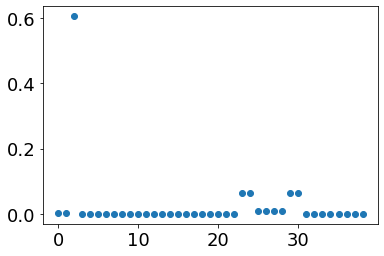

In [88]:
plt.scatter(range(nions), atom_attr)

Text(0.5, 1.0, 'qmof-8a95c27')

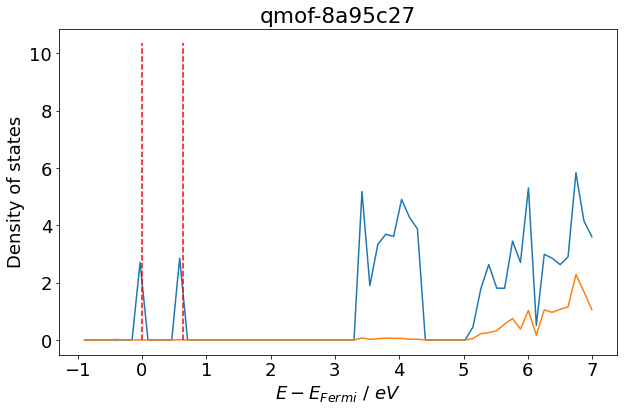

In [92]:
energies = dos_data[:,0]
atom_dos_sum = np.sum(atom_dos_data, axis=2) - energies

atom_idx = 0

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.plot(
    energies[(energies>efermi-1) & (energies<efermi+7)]-efermi,
    dos_data[:, 2][(energies>efermi-1) & (energies<efermi+7)], 
    #gaussian_filter1d(dos_data[:, 1][(energies>efermi-1) & (energies<efermi+7)], sigma=bandgap)
)

ax.plot(
    energies[(energies>efermi-1) & (energies<efermi+7)]-efermi, 
    atom_dos_sum[atom_idx,:][(energies>efermi-1) & (energies<efermi+7)]  
)

ax.plot([0,0], [0,np.max(dos_data[:, 1][(energies>efermi-1) & (energies<efermi+7)])], 'r--')
ax.plot([bandgap, bandgap], [0,np.max(dos_data[:, 1][(energies>efermi-1) & (energies<efermi+7)])], 'r--')
ax.set_xlabel("$E-E_{Fermi}\ /\ eV$")
ax.set_ylabel("Density of states")
ax.set_title("%s" %qmof_id)

# read qmofs with peaks in the bandgap

In [130]:
with open("../files/mofs_with_peaks") as f:
    mofs_peak = [l.split() for l in f.readlines()]

In [131]:
len(mofs_peak)

4357

In [133]:
qmof_id_peak = [qmof_df[qmof_df["name"] == q[0]].index.item() for q in mofs_peak]

In [134]:
len(qmof_id_peak)

4357

In [135]:
if "qmof-8a95c27" not in qmof_id_peak:
    print("yes")

yes


In [17]:
import shutil

In [20]:
for x in qmof_id_peak:
    src = os.path.join("/run/user/1001/gvfs/smb-share:server=lsmosrv2.epfl.ch,share=xiazhang/dos_plots", x+".png")
    dst = os.path.join("/run/user/1001/gvfs/smb-share:server=lsmosrv2.epfl.ch,share=xiazhang/dos_plots_peaks", x+".png")
    shutil.copyfile(src, dst)

# check the label distribution

In [76]:
label_data = pd.read_json("../files/qmof_update.json")

(array([1.1547e+04, 4.0300e+03, 2.3860e+03, 9.7800e+02, 6.8100e+02,
        1.8900e+02, 1.9800e+02, 1.3200e+02, 1.2100e+02, 3.0000e+01,
        1.5000e+01, 8.0000e+00, 1.2000e+01, 1.0000e+01, 6.0000e+00,
        4.0000e+00, 1.1000e+01, 2.0000e+00, 3.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0.        ,   8.93603658,  17.87207316,  26.80810974,
         35.74414632,  44.6801829 ,  53.61621948,  62.55225606,
         71.48829264,  80.42432922,  89.3603658 ,  98.29640238,
        107.23243896, 116.16847554, 125.10451212, 134.0405487 ,
        142.97658528, 151.91262186, 160.84865844, 169.78469502

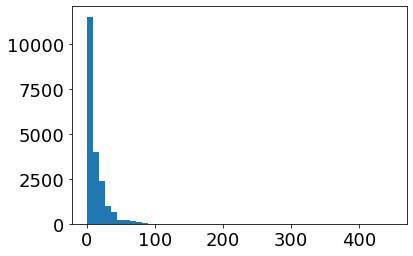

In [78]:
plt.hist(label_data["dos_in_bandgap"], bins=50)